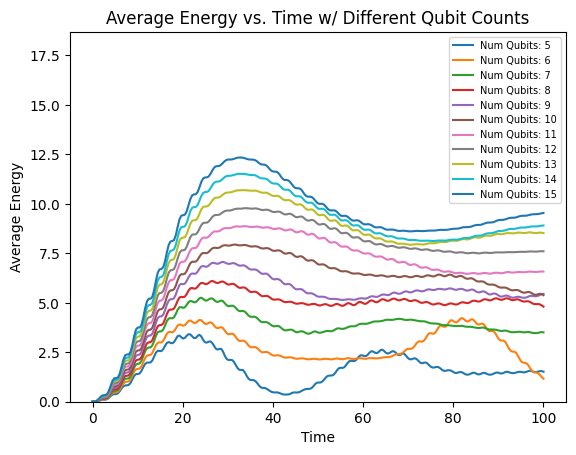

In [1]:
from quantumScarFunctions import *
from scipy.sparse import csr_matrix
import qutip as qt
import matplotlib.pyplot as plt
from quantumScarsPlotting import *

# average energy vs time with wc for qubits 5 to 15
wc = 1.2474747
numQubits = 15
tlist = np.linspace(0, 100, 250)
args_wc = {"A": 0.1, "omega": wc}

# flip bit hashmap
flipMap = {'0': '1', '1': '0'}

plt.figure()

for n in range(5, numQubits + 1):
    basisList = binNoConsecOnesEfficient(n)
    basisMap = {bitStr: i for i, bitStr in enumerate(basisList)}
    basisLen = len(basisList)
    flippedList = []

    row = []
    column = []

    for i in range(basisLen):

        # add padding so that search doesnt go out of range
        paddedBitStr = '0' + basisList[i] + '0'
        copyBit = list(paddedBitStr)

        # apply the sum of r P_r-1 * sigma_x * P_r+1 operator
        for j in range(1, n+1):
            
            if paddedBitStr[j-1] == '0' and paddedBitStr[j+1] == '0':
                copyBit[j] = flipMap[paddedBitStr[j]]
                flippedList.append(''.join(copyBit)[1:-1])
                copyBit = list(paddedBitStr)
            
        # adds row and column values for the sparse matrix
        for k in range(len(flippedList)):
            
            row.append(basisMap[flippedList[k]])
            column.append(i)
            
        flippedList.clear()

    # list of ones for the sparse matrix
    onesList = np.ones(len(row), dtype=int)

    # create the sparse matrix and turn it into a Qobj
    sparseHamiltonian = csr_matrix((onesList, (row, column)), shape=[basisLen, basisLen])
    matrixHamiltonian = sparseHamiltonian.toarray()
    matrixHamiltonian = qt.Qobj(matrixHamiltonian)

    # diagonalize the sparse matrix
    eigenvalues, eigenstates = matrixHamiltonian.eigenstates()

    # create H1 operator for QobjEvo!
    copyBasis = basisList
    diagH1 = []

    # switches 0s to -1s and keeps 1s the same for the copyBasis
    # appends to diagH1 the dot product between each bit string and the 0 -> -1 Z2 state
    for i in range(basisLen):

        bitString = list(copyBasis[i])
        bitString = [int(i) for i in bitString]

        z2bitString = list(z2_initial(n))
        z2bitString = 2 * np.array([int(i) for i in z2bitString]) - 1

        diagH1.append(np.dot(2 * np.array(bitString) - 1, z2bitString))

    # rows and columns lists for diagonal positions in H1
    rowH1 = [i for i in range(basisLen)]
    columnH1 = [i for i in range(basisLen)]

    # creates sparse matrix with diagonals as diagH1 list
    H1 = csr_matrix((diagH1, (rowH1, columnH1)), shape=[basisLen, basisLen])
    H1 = qt.Qobj(H1)

    H = qt.QobjEvo([matrixHamiltonian, [H1, coeff]], args=args_wc) # create H using QobjEvo
    psi_t = qt.sesolve(H, eigenstates[0], tlist) # evolve the H through time
    tempExpectation = []

    for states in psi_t.states:

        val = states.dag() * matrixHamiltonian * states
        tempExpectation.append(val.real)

    tempExpectation = np.array(tempExpectation)
    tempExpectation = tempExpectation - tempExpectation[0]
    plt.plot(tlist, tempExpectation, label=f"Num Qubits: {n}")

plt.xlabel("Time")
plt.ylabel("Average Energy")
plt.title("Average Energy vs. Time w/ Different Qubit Counts")
plt.ylim(eigenvalues[0] - eigenvalues[0], eigenvalues[-1] - eigenvalues[0])
plt.legend(loc='upper right', fontsize=7)
plt.show()